In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import scipy.integrate as integrate
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'torch'

In [29]:
df = pd.read_csv('Sweden Load Data 2005-2017.csv')
df.rename({'cet_cest_timestamp':'time','SE_load_actual_tso':'load'},axis='columns',inplace=True)
df['time'] = pd.to_datetime(df['time'],errors='ignore', utc=True)
df['weekday'] = df['time'].dt.weekday
realtime_pv = [0, 0, 0, 0, 0, 0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9, 1, 1, 0.9, 0.8, 0.6, 0.4, 0.1, 0, 0, 0, 0, 0]
realtime_pv = [i * 7200 for i in realtime_pv]

In [30]:
class Env:
    def __init__(self,array_loads,array_weekdays,charge=4,action=None,num=7):
        self.array_loads = array_loads
        self.array_weekdays = array_weekdays
        self.charge = charge
        self.action = action
        self.load_idx = 0
        self.day_idx = 0
        self.collection_actual_load = []
        self.collection_rewards = []
        self.day_actual_load = []
        self.cost_list=[]
        self.reference_list=[]
        self.actual_load=None
        self.reward = 0
        self.episode=0
        self.num=num
        self.queue = [0 for i in range(self.num)]
        
    def increase_load_counter(self):
        self.load_idx+=1
    def clear(self):
        self.load_idx = 0
        self.day_idx = 0
        self.collection_actual_load = []
        self.collection_rewards = []
        self.day_actual_load = []
        self.cost_list=[]
        self.reference_list=[]
        self.actual_load=None
        self.reward = 0
        self.episode=0
        self.queue = [0 for i in range(self.num)]

    def increase_day_counter(self):
        self.day_idx+=1
        
    def generate_input_load(self):
        self.input_load = self.array_loads[self.load_idx]

    def generate_input_pv(self):
        self.input_pv = realtime_pv[self.load_idx % 24]
        
    def calculate_actual_load(self):
        self.charge_amount = 3500

        if self.action == None:
            self.actual_load = self.input_load - self.input_pv
            self.collection_actual_load.append(self.actual_load)
            self.increase_load_counter()

        elif self.action == 'discharge' and self.charge != 0:

            self.actual_load = self.input_load - self.input_pv - self.charge_amount
            self.collection_actual_load.append(self.actual_load)
            self.increase_load_counter()
            self.charge -= 1

        elif self.action == 'charge' and self.charge != 4:

            self.actual_load = self.input_load - self.input_pv + self.charge_amount
            self.collection_actual_load.append(self.actual_load)
            self.increase_load_counter()
            self.charge += 1

        else:
            self.actual_load = self.input_load
            self.collection_actual_load.append(self.actual_load)
            self.increase_load_counter()

            
    def reward_function_v1(self):
        alpha = 0.7
        eprice = [0.082, 0.113, 0.17]
        t = self.load_idx % 24
        # if (t < 6) or (t >= 23):
        #     v_0 = 1.025
        # if (t >= 6) and (t <= 16):
        #     v_0 = 1.01
        # if (t > 16) or (t < 23):
        #     v_0 = 0.975

        if (t < 7) or (t >= 19):
            reward = alpha * self.collection_actual_load[-1] * eprice[1] - (1-alpha)* 0.1628* (self.collection_actual_load[-1] - self.collection_actual_load[-2])/3600

        if (t >= 11) or (t < 17):
            reward = alpha*self.collection_actual_load[-1] * eprice[2] - (1-alpha)* 0.1628*(self.collection_actual_load[-1] - self.collection_actual_load[-2])/3600

        if ((t >= 7) and (t < 11)) or ((t >= 17) and (t < 19)):
            reward = alpha*self.collection_actual_load[-1] * eprice[3] - (1-alpha)* 0.1628*(self.collection_actual_load[-1] - self.collection_actual_load[-2])/3600


        self.cost_list.append(reward)
        #self.reference_list.append(cost_input)
        return reward
    
    
    def calculate_reward(self):
        self.increase_day_counter()
        if self.array_weekdays[self.day_idx] == self.array_weekdays[self.day_idx-1]:
            self.reward = 0
            self.collection_rewards.append(self.reward)
        else:
            #cost function
            self.reward = self.reward_function_v1()
            self.collection_rewards.append(self.reward)
            self.episode+=1

In [31]:
class PolicyNetwork(nn.Module):
    """
    PGN-Policy Gradient Network (Function Approximator):
    
    - input size: number of observation states in environment
    - n_actions: number of actions in environment
    
    We will use neural network with one hidden layer, which 
    has one hidden layer with 128 neurons and ReLU activation function, 
    as was described in report. So, our vector of \theta parameters 
    will have 128 elements. 
    
    """
    # initialization function
    def __init__(self, input_size, n_actions):
        super(PolicyNetwork, self).__init__()
        
        #torch.manual_seed(3)
        # Creating a simple neural network with 128 parameters \theta
        # in one hidden layer 
        # Softmax activation will be done in the algorithm later.
        #self.net = nn.Sequential(
            #nn.Linear(input_size, 512),
            #nn.ReLU(),
            #nn.Linear(512, 126),
            #nn.ReLU(),
            #nn.Linear(126, 64),
            #nn.ReLU(),
            #nn.Linear(64, n_actions),
            #nn.Softmax(dim=1)
        #)
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 126)
        self.fc3 = nn.Linear(126, 64)
        self.fc4 = nn.Linear(64, n_actions)
    # forward propagation function
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [32]:
net = PolicyNetwork(3, 3)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model = PolicyNetwork(3, 3)
model.fc2.register_forward_hook(get_activation('fc2'))
x = torch.randn(1, 3)
output = model(x)

def get_feature(net, x):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    net.fc1.register_forward_hook(get_activation('fc1'))
    net.fc2.register_forward_hook(get_activation('fc2'))
    net.fc3.register_forward_hook(get_activation('fc3'))
    net.fc4.register_forward_hook(get_activation('fc4'))
    output = net(x)
    return activation

In [33]:
net = PolicyNetwork(3, 3)
x = torch.randn(1, 3)
out = get_feature(net, x)

In [34]:
def compute_q_vals(rewards):
    """
    rewards: list of rewards collected in episode
    """
    res = []
    sum_r = 0.0
    # looping through the list of rewards in reverse order
    # because in REINFORCE (look at report pseudocode)
    # last action receives one last reward, pre-last action
    # receives pre-last reward plus discounted last etc.:
    for r in reversed(rewards):
        sum_r *= 0.99
        sum_r += r
        res.append(sum_r)
    # we againg reverse our list of rewards per action
    # in the order actions appeared
    return list(reversed(res))

In [35]:
eps = np.finfo(float).eps
#array_loads = df['load'].diff(24).diff(24*7).diff(24*7*4).diff(24*7*4*12)
array_loads = df['load']
array_weekdays = df['weekday']+1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
new_data = scaler.fit_transform(array_loads.values[:, np.newaxis])
new_data = new_data.reshape(1,-1)[0]
array_loads = new_data

In [36]:
array_loads_test = array_loads[-1000:]
array_weekdays_test = array_weekdays[-1000:]
print(array_weekdays_test)
array_loads_train = array_loads[:-11395]
array_weekdays_train = array_weekdays[:-11395]
array_loads_train_conv = array_loads[:-100000]
array_weekdays_train_conv = array_weekdays[:-100000]

112951    1
112952    1
112953    1
112954    1
112955    1
112956    1
112957    1
112958    1
112959    1
112960    1
112961    1
112962    1
112963    1
112964    1
112965    1
112966    1
112967    1
112968    2
112969    2
112970    2
112971    2
112972    2
112973    2
112974    2
112975    2
112976    2
112977    2
112978    2
112979    2
112980    2
112981    2
112982    2
112983    2
112984    2
112985    2
112986    2
112987    2
112988    2
112989    2
112990    2
112991    2
112992    3
112993    3
112994    3
112995    3
112996    3
112997    3
112998    3
112999    3
113000    3
113001    3
113002    3
113003    3
113004    3
113005    3
113006    3
113007    3
113008    3
113009    3
113010    3
113011    3
113012    3
113013    3
113014    3
113015    3
113016    4
113017    4
113018    4
113019    4
113020    4
113021    4
113022    4
113023    4
113024    4
113025    4
113026    4
113027    4
113028    4
113029    4
113030    4
113031    4
113032    4
113033    4
1130

In [37]:
def main(lr, n, m, clip_grad=False):
    if clip_grad:
        CLIP_GRAD=0.1
    #STARTING EPISODE
    env1 = Env(array_loads_train, array_weekdays_train)
    env1.generate_input_load()
    env1.generate_input_pv()
    env1.calculate_actual_load()

    #number of episodes (days) used for 1 backprop
    n=n
    loss_list=[]
    action_list=[]
    norm_grad_list = []
    mean_rewards_list = []
    torch.manual_seed(0)
    net = PolicyNetwork(3, 3)

    optimizer = optim.Adam(net.parameters(), lr=lr)

    #create list for collecting total rewards
    total_rewards = []

    map_action = {0:'discharge',1:'charge',2:'wait'}

    batch_states, batch_actions, batch_qvals, batch_times = [], [], [], []
    cur_rewards = []
    np.random.seed(0)
    for j in range(0, m):
        env1.clear()
        env1.generate_input_load()
        env1.generate_input_pv()
        env1.calculate_actual_load()
        #years of data for pass
        for i in range(len(array_loads_train) - 1):
            obs = np.array([env1.actual_load])
            obs_v = torch.FloatTensor(obs)
            batch_states.append([env1.load_idx % 24, obs, env1.input_pv])
            logits_v = net(torch.tensor([env1.load_idx % 24,obs_v, env1.input_pv]))
            probs = F.softmax(logits_v).detach().numpy()
            action = np.random.choice(np.array([0,1,2]),p=np.array(probs).round(4))
            env1.action=map_action[action]
            action_list.append(env1.action)
            env1.generate_input_load()
            env1.generate_input_pv()
            env1.calculate_actual_load()
            env1.calculate_reward()
            batch_actions.append(np.array([action]))
            cur_rewards.append(env1.reward)
            if env1.episode<n:
                continue

            cur_rewards = np.array(cur_rewards)
            #cur_rewards = (cur_rewards - cur_rewards.mean()) / (cur_rewards.std()+eps)
            total_rewards.append(sum(cur_rewards)/n)
            mean_reward = float(np.mean(total_rewards[-7:]))
            mean_rewards_list.append(mean_reward)
            optimizer.zero_grad()
            batch_qvals.extend(compute_q_vals(cur_rewards))
            cur_rewards=list(cur_rewards)
            cur_rewards.clear()

            states_v = torch.FloatTensor(batch_states)
            batch_actions_t = torch.LongTensor(batch_actions)
            batch_qvals_v = torch.FloatTensor(batch_qvals)

            # neural network, log softmax, q_vals * log_softmax, loss, backprop
            logits_v = net(states_v)
            log_prob_v = F.log_softmax(logits_v, dim=1)
            out, _ = torch.max(batch_actions_t,dim=1)
            log_prob_actions_v = batch_qvals_v*log_prob_v[range(len(batch_states)),out]
            loss_v = -log_prob_actions_v.mean()
            #loss_list.append(loss_v)  
            loss_v.backward()
            #nn.utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
            optimizer.step()

            #let's find grads and grads norm and variance
            grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                                                            for p in net.parameters()
                                                            if p.grad is not None])
            norm_grad = np.linalg.norm(grads)
            norm_grad_list.append(norm_grad)
            batch_states.clear()
            batch_actions.clear()
            batch_qvals.clear()
            env1.episode = 0
    return env1,mean_rewards_list,total_rewards, net

In [38]:
_, mean_rewards_list, total_rewards, policy=main(0.0003, 30, 5)
#torch.save(net.state_dict(), 'strange_model.pt')

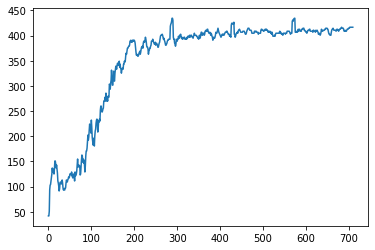

In [39]:
plt.plot(np.arange(len(mean_rewards_list)),mean_rewards_list)
plt.show()

In [40]:
import collections
def profile_DNN(net, array_loads, array_weekdays, array_weekdays_idx):
    """
    Profile the DNN and return a cov_dict contains the necessary information
    ---
    Args
        net: torch.nn.Module Deep learning model.
        dataloader: torch.utils.data.DataLoader The pytorch dataloader.
    Returns:
        cov_dict: a dict contains (layer_name, neuron_id) --> (neurons_min, neurons_max) mapping.
    
    """
    net.eval()
    cov_dict = collections.OrderedDict()
    env1 = Env(array_loads, array_weekdays)
    env1.day_idx = array_weekdays_idx
    map_action = {0:'discharge',1:'charge',2:'wait'}
    name_list = ['fc1', 'fc2', 'fc3', 'fc4']
    batch_num = len(array_loads)
    for i in range(len(array_loads) - 1):
        env1.generate_input_load()
        env1.generate_input_pv()
        env1.calculate_actual_load()
        env1.calculate_reward()
        obs = np.array([env1.actual_load])
        obs_v = torch.FloatTensor(obs)
        logits_v = net(torch.tensor([env1.load_idx % 24,obs_v, env1.input_pv]))
        probs = F.softmax(logits_v).detach().numpy()
        action = np.random.choice(np.array([0,1,2]),p=np.array(probs).round(4))
        env1.action=map_action[action]
        with torch.no_grad():
            out_list = get_feature(net, torch.tensor([env1.load_idx % 24,obs_v, env1.input_pv]))
        if i % 10000 == 0:
            print("* finish {}/{} proportion".format(i, batch_num))
        # Iterate through all output layers in the output list
        for layer_id in range(len(out_list)):
            cur_layer = name_list[layer_id] # record the name of current layer
            
            '''
            Recall the definition of neurons. For a linear layer, the output is [Batch_size, neurons]
            While for a convolutional layer, the output is [Batch_size, channel, H, w]
            As we define that every entry in the 3D output volume is one neuron, 
            the number of neurons in conv layer is just channel * H * W.
            '''
            
            cur_neuron_num = 1
            
            '''
            Please compute the number of neurons in the DNN and store the result in cur_neuron_num.
            '''
            # ======Below is TODO====== #
            if len(list(out_list[cur_layer].shape)) == 4:
              N, C, H, W = out_list[cur_layer].shape
              cur_neuron_num = C * H * W
            elif len(list(out_list[cur_layer].shape)) == 2:
              N, cur_neuron_num = out_list[cur_layer].shape
            elif len(list(out_list[cur_layer].shape)) == 1:
              N, cur_neuron_num = 1, out_list[cur_layer].shape[0]
            # ======Above is TODO====== #
            
            '''
            Please records the max value and min value over **batch** (the first dimension) from the **out_list**
            Hint: you can use torch.flatten or reshape to turn a multi-dimension tensor
            into one-dimension tensor to [C, H, W] --> [N] can be easily used to represent neurons.
            Data structure used here: out_list, neurons_max, neurons_min
            '''
            
            # ======Below is TODO====== #
            flat = torch.reshape(out_list[cur_layer], (N, cur_neuron_num))
            neurons_max, _ = torch.max(flat, dim=0)
            neurons_min, _ = torch.min(flat, dim=0)
            # ======Above is TODO====== #

            for neuron_id in range(cur_neuron_num):
                # Please record the range of the neuron for key (cur_layer, neuron_id).
                if (cur_layer, neuron_id) not in cov_dict:
                    # The fisrt time to record the pair.
                    cov_dict[(cur_layer, neuron_id)] = [None, None] # Initialize [Lower, upper]
                
                profile_data_list = cov_dict[(cur_layer, neuron_id)]

                '''
                Please compare the result in neurons_max, neurons_min with that in profile_data_list
                If neurons_max is larger than the data in profile_data_list
                store it in the upper_bound and store back to the profile_data_list.
                Data structure used here: lower_bound, upper_bound, neurons_min, neurons_max
                '''
                
                # ======Below is TODO====== #
                lower_bound, upper_bound = profile_data_list
                if lower_bound == None:
                  lower_bound = neurons_min[neuron_id]
                else:
                  lower_bound = min(lower_bound, neurons_min[neuron_id])

                if upper_bound == None:
                  upper_bound = neurons_max[neuron_id]
                else:
                  upper_bound = max(upper_bound, neurons_max[neuron_id])
                
                # ======Above is TODO====== #
                
                profile_data_list[0] = lower_bound
                profile_data_list[1] = upper_bound
                cov_dict[(cur_layer, neuron_id)] = profile_data_list
            
    return cov_dict

In [41]:
cov_dict = profile_DNN(policy, array_loads_train_conv, array_weekdays_train_conv, 0)

* finish 0/13951 proportion
* finish 10000/13951 proportion


In [42]:
def compute_NBCov(net, array_loads, array_weekdays, cov_dict, array_weekdays_idx):
    """
    Compute the Neuron Boundary Coverage metric on a given data loader. 
    ---
    Args
        net: torch.nn.Module Deep learning model.
        dataloader: torch.utils.data.DataLoader The pytorch dataloader.
        cov_dict: a dict contains (layer_name, neuron_id) --> (neurons_min, neurons_max) mapping.
    Returns:
        result: the coverage result
    
    """
    net.eval()
    coverage_recorder = collections.OrderedDict()
    env1 = Env(array_loads, array_weekdays)
    env1.day_idx = array_weekdays_idx
    map_action = {0:'discharge',1:'charge',2:'wait'}
    name_list = ['fc1', 'fc2', 'fc3', 'fc4']
    batch_num = len(array_loads)
    
    for i in range(len(array_loads) - 2):
        env1.generate_input_load()
        env1.generate_input_pv()
        env1.calculate_actual_load()
        env1.calculate_reward()
        obs = np.array([env1.actual_load])
        obs_v = torch.FloatTensor(obs)
        logits_v = net(torch.tensor([env1.load_idx % 24,obs_v, env1.input_pv]))
        probs = F.softmax(logits_v).detach().numpy()
        action = np.random.choice(np.array([0,1,2]),p=np.array(probs).round(4))
        env1.action=map_action[action]
        with torch.no_grad():
            out_list =  get_feature(net, torch.tensor([env1.load_idx % 24,obs_v, env1.input_pv]))
        if i % 100 == 0:
            print("* finish {}/{} proportion".format(i, batch_num))
        
        # Iterate through all output layers in the output list
        for layer_id in range(len(out_list)):
            # record the name of current layer
            cur_layer = name_list[layer_id]
            cur_neuron_num = 1
            
            '''
            Please compute the number of neurons in the DNN and store the result in cur_neuron_num.
            Compute neurons_max and neurons_min based on **out_list**
            '''

            # ======Below is TODO====== #
            if len(list(out_list[cur_layer].shape)) == 4:
              N, C, H, W = out_list[cur_layer].shape
              cur_neuron_num = C * H * W
            elif len(list(out_list[cur_layer].shape)) == 2:
              N, cur_neuron_num = out_list[cur_layer].shape
            elif len(list(out_list[cur_layer].shape)) == 1:
              N, cur_neuron_num = 1, out_list[cur_layer].shape[0]
            flat = torch.reshape(out_list[cur_layer], (N, cur_neuron_num))
            neurons_max, _ = torch.max(flat, dim=0)
            neurons_min, _ = torch.min(flat, dim=0)
            # ======Above is TODO====== #

            # Compare the result in cov_dict and record neurons who has been covered.
            for neuron_id in range(cur_neuron_num):
                if (cur_layer, neuron_id) not in coverage_recorder:
                    # Init the coverage_recorder
                    # [(cur_layer, neuron_id)] = [0, 0] (LowerCornerNeuron, UpperCornerNeuron)
                    coverage_recorder[(cur_layer, neuron_id)] = [0, 0] # LowerCornerNeuron, UpperCornerNeuron
                
                '''
                Compare the output in neurons_min(neurons_max) and and cov_dict
                If the neuron is covered in LowerCorner, set LowerCornerNeuron = 1
                If the neuron is covered in UpperCorner, set UpperCornerNeuron = 1
                Data sturcture used here: cov_dict, neurons_min, neurons_max, coverage_recorder
                '''
                
                # ======Below is TODO====== #
                if neurons_max[neuron_id] > cov_dict[(cur_layer, neuron_id)][1]:
                  coverage_recorder[(cur_layer, neuron_id)][1] = 1
                if neurons_min[neuron_id] < cov_dict[(cur_layer, neuron_id)][0]:
                  coverage_recorder[(cur_layer, neuron_id)][0] = 1

                # ======Above is TODO====== #
    
    num_of_coverage_neuron = 0
    
    '''
    Compute the number of neurons that are covered
    Data sturcture used here: coverage_recorder, result
    '''
    
    # ======Below is TODO====== #
    count = 0
    for key, value in coverage_recorder.items():
      count += 1
      if value[0] == 1:
        num_of_coverage_neuron += 1
      if value[1] == 1:
        num_of_coverage_neuron += 1
    result = num_of_coverage_neuron / (count * 2)
    # ======Above is TODO====== #
    
    return result

In [43]:
realtime_pv = [0, 0, 0, 0, 0, 0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9, 1, 1, 0.9, 0.8, 0.6, 0.4, 0.1, 0, 0, 0, 0, 0]
realtime_pv = [i * 7200 for i in realtime_pv]
array_loads_test = array_loads[-1000:]
array_weekdays_test = array_weekdays[-1000:]
cov_result = compute_NBCov(policy, array_loads_test, array_weekdays_test, cov_dict, 112952)
print(cov_result)

* finish 0/1000 proportion
* finish 100/1000 proportion
* finish 200/1000 proportion
* finish 300/1000 proportion
* finish 400/1000 proportion
* finish 500/1000 proportion
* finish 600/1000 proportion
* finish 700/1000 proportion
* finish 800/1000 proportion
* finish 900/1000 proportion
0.18368794326241134


In [44]:
realtime_pv = [0, 0, 0, 0, 0, 0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9, 1, 1, 0.9, 0.8, 0.6, 0.4, 0.1, 0, 0, 0, 0, 0]
realtime_pv = [i * 7200 for i in realtime_pv]
realtime_pv = [i * 0.8 for i in realtime_pv]  # mutate
array_loads_test = array_loads[-1000:]
array_loads_test = array_loads_test * 1.2 #mutate
cov_result = compute_NBCov(policy, array_loads_test, array_weekdays_test, cov_dict, 112952)
print(cov_result)

* finish 0/1000 proportion
* finish 100/1000 proportion
* finish 200/1000 proportion
* finish 300/1000 proportion
